In [1]:
import torch
import sys
import numpy as np
from matplotlib import pyplot as plt

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from AttentionUnet import UNetWithAttention, inference_image, inference_dataset, img_kp_pred_and_gr_new, load_keypoints_from_csv

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from AttentionUnet import inference_F1map_unet

datapath = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/416px'
output_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/416px/output'
model_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/416px/best_unet5.pth'

f1_matrix = inference_F1map_unet(
    dataset_path=datapath,
    model_path=model_path,
    img_size=416,
    pixel_thresholds=[2,3,4,5,6,7],
    binary_thresholds=np.arange(0.80, 1, 0.005),
    beta=1
)


[INFO] Calcolo con binary_threshold=0.800 ...


KeyboardInterrupt: 

In [2]:
# da f1 matrix estrapola valore max di binary threshold @4px
import pandas as pd

datapath = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/416px'
output_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/416px/output'
model_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/416px/best_unet5.pth'

f1_matrix = pd.read_csv(
    '/user/gr1/delphi/dghezzi/UNet/SharedDataset/416px/beta=1/BCEL1dice/F1_matrix_unet.csv',
    header=None
).values

thresholds = np.loadtxt('/user/gr1/delphi/dghezzi/UNet/SharedDataset/416px/beta=1/BCEL1dice/F1_axis_pixel_thresholds.csv', delimiter=',')
binary = np.loadtxt('/user/gr1/delphi/dghezzi/UNet/SharedDataset/416px/beta=1/BCEL1dice/F1_axis_binary_thresholds.csv', delimiter=',')

idx = np.where(thresholds == 4)[0][0]
f1_at_threshold = f1_matrix[:, idx]
max_binary = binary[np.argmax(f1_at_threshold)]

print(f'best binary threshold @4px is {max_binary}')
print(f1_at_threshold[np.argmax(f1_at_threshold)])

best binary threshold @4px is 0.96
0.546


In [3]:
stats = inference_dataset(
    datapath=datapath,
    model_path=model_path,
    output_path=output_path,
    threshold=binary[np.argmax(f1_at_threshold)],
    pixel_thresholds=[4],
    beta=1
)

print(stats)


== Average results over 2500 images ==
Threshold 4.0px ==> Precision: 0.905 | Recall: 0.390 | F1: 0.544
Inference time: ( 20.041 ± 0.369 ) ms/image
Predicted keypoints: ( 69.95 ± 0.11 ) per image
{'thresholds': [4], 'precision': [0.9049905771493882], 'recall': [0.3900216490338949], 'f1': [0.5444296217082055], 'std_f1': [0.0347256269332687], 'stdmean_f1': [0.000694512538665374], 'avg_inference_time_sec': 0.0200407338142395, 'std_inference_time_sec': 0.00036929682375285116, 'avg_pred_keypoints': 69.952, 'std_pred_keypoints': 0.10842305289927967, 'mean_red_precision': [0.8698240503204124], 'mean_red_recall': [0.3031992031940376], 'mean_red_f1': [0.4488215104420684], 'mean_number_predKP_centered': 43.948, 'mean_number_gtKP_centered': 126.2656, 'mean_per_precision': [0.9524759979298093], 'mean_per_recall': [0.6870964224748741], 'mean_per_f1': [0.7963079239549016], 'mean_number_predKP_peripheral': 26.004, 'mean_number_gtKP_peripheral': 36.1736}


il valore di F1 con beta=1 e beta=2 sono uguali per max binary confidence!!!

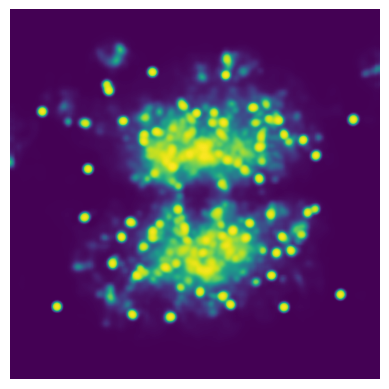

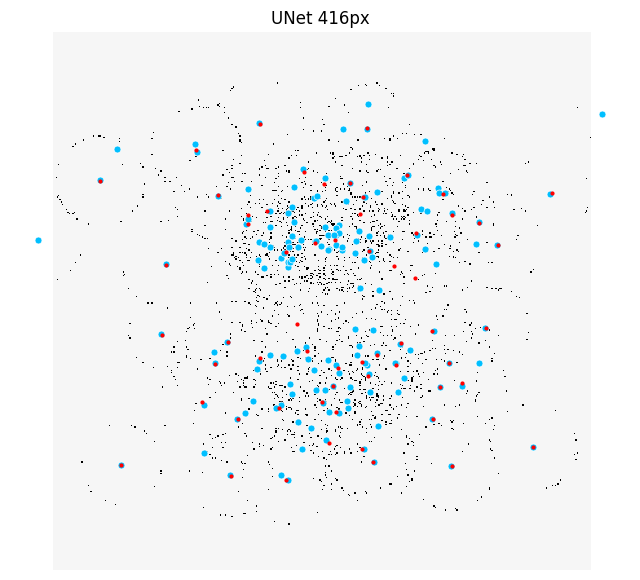

In [8]:
import torch
from AttentionUnet import UNetWithAttention

img_path = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/416px/images/val/event_8.npy'
csv_path = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/416px/centers/val/event_8_centers.csv'

device = 'cuda'

model = UNetWithAttention(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

heatmap, kp_cov, time = inference_image(img_path, model=model, device=device, threshold=max_binary, npy=True, sigmoid=True, beta=1)
kp = [kp for kp, cov in kp_cov]
gt_kp = load_keypoints_from_csv(csv_path)
img_kp_pred_and_gr_new(kp, gt_kp, img_path, title='UNet 416px') 